In [1]:
import os
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import math
from ipywidgets import widgets, Checkbox, FloatSlider, IntSlider, IntRangeSlider, FloatRangeSlider, RadioButtons
from IPython.core.display import clear_output, display

from moviepy.editor import VideoFileClip
from IPython.display import HTML

from image_pipeline import Operation, Color, Sobel, Magnitude, Direction, \
  Threshold, Combinator, FindLinesSlidingWindows, Annotate, ImagePipeline

In [2]:
ip = ImagePipeline(input_color='bgr')
ip.calibrate(glob.glob('camera_cal/calibration*.jpg'))
mtx = ip.mtx
dist = ip.dist

In [12]:
ip_vid = ImagePipeline(input_color='rgb')

src = np.float32([[  100.,   720.],
                  [  542.,   470.],
                  [  738.,   470.],
                  [ 1180.,   720.]])

# Choose x positions that allow for 3.7m for the lane position closest to car.
dst = np.float32([[ 225.,  720.],
                  [ 225.,    0.],
                  [ 1055.,    0.],
                  [ 1055.,  720.]])

ip_vid.set_perspective(src, dst)

ip_vid.mtx = mtx
ip_vid.dist = dist

t1 = Threshold(trange=(1, 255), crop_b=50)
t1.add(Color(['h', 'l', 's'], in_range=((20, 100, 12), (138, 255, 255))))
ip_vid.add(t1)

t2 = Threshold(trange=(1, 255), crop_b=50)
t2.add(Color(['h', 'l', 's'], in_range=((0, 202, 0), (255, 255, 255))))
ip_vid.add(t2)

t3 = Threshold(trange=(4, 161), crop_b=50)
t3.add(Color(['s']))
t3.add(Sobel('y', kernel=15))
t3.add(Magnitude())
ip_vid.add(t3)


c = Combinator(f=(lambda ths: np.where(((ths[0] == 1) | (ths[1] == 1)) & (ths[2] == 1))))
# c = Combinator(f=(lambda ths: np.where((ths[0] == 1))))
ip_vid.add(c)
f = FindLinesSlidingWindows(always_recalculate=False)
ip_vid.add(f)

an = Annotate(f)
ip_vid.add(an)

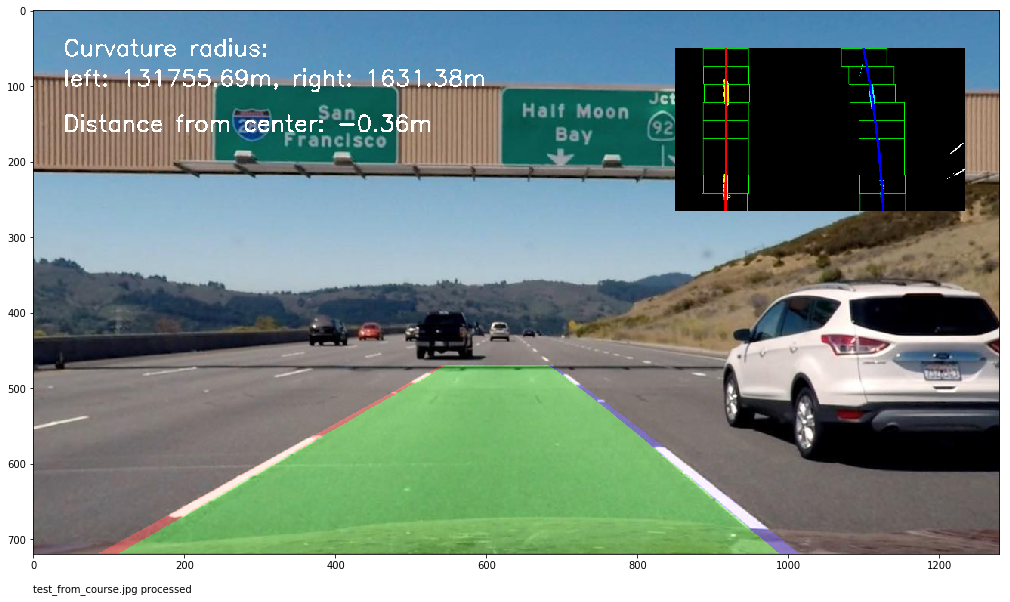

In [36]:
# test_images = glob.glob('test_images/*.jpg')
# sample = test_images

i = 0
sample = ['test_images/test_from_course.jpg']
fig = plt.figure(figsize=(18, 10*len(sample)))
for fname in sample:
    f.reset()
    name = os.path.basename(fname)
    img = cv2.imread(fname)
    img = cv2.resize(img, (1280, 720))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    processed = ip_vid.process(img)
    a = fig.add_subplot(math.ceil(float(len(sample))/1.), 1, i+1)
    plt.imshow(processed)

    plt.text(0, 770, "{} processed".format(name))
    i+=1

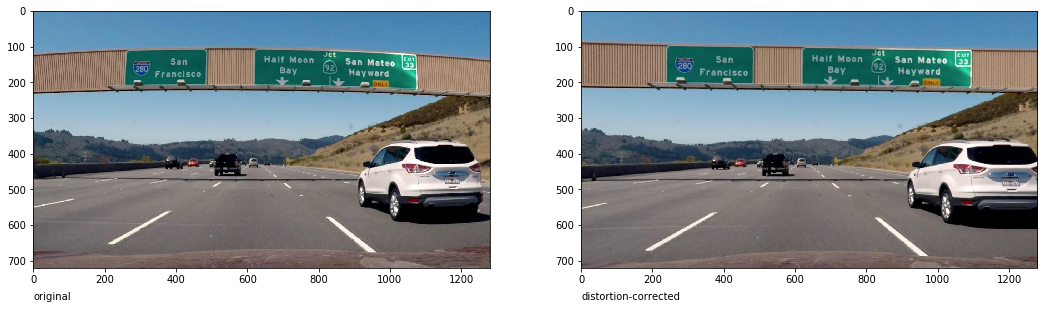

In [18]:
fig = plt.figure(figsize=(18, 8))
a = fig.add_subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread(sample[0]), cv2.COLOR_BGR2RGB))
plt.text(0, 810, "original")
a = fig.add_subplot(1, 2, 2)
plt.imshow(ip_vid.undist_img)
_ = plt.text(0, 810, "distortion-corrected")

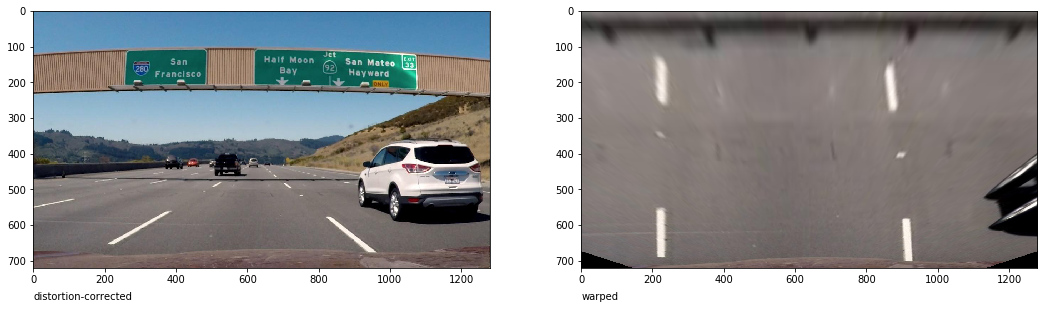

In [19]:
fig = plt.figure(figsize=(18, 8))
a = fig.add_subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread(sample[0]), cv2.COLOR_BGR2RGB))
plt.text(0, 810, "distortion-corrected")
a = fig.add_subplot(1, 2, 2)
plt.imshow(ip_vid.warped_img)
_ = plt.text(0, 810, "warped")

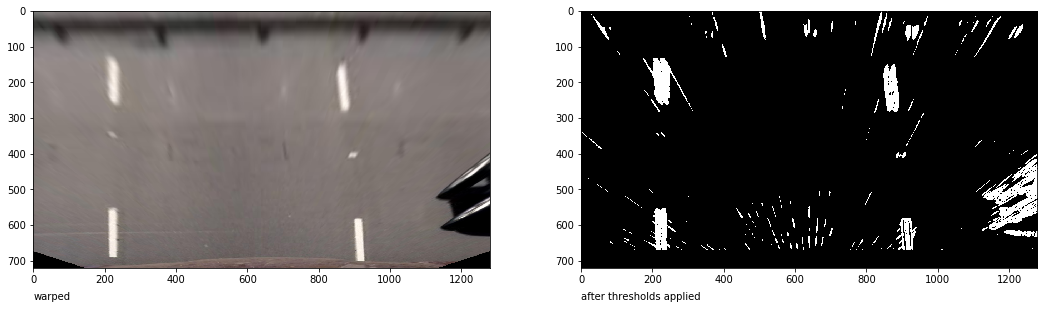

In [21]:
fig = plt.figure(figsize=(18, 8))
a = fig.add_subplot(1, 2, 1)
plt.imshow(ip_vid.warped_img)
plt.text(0, 810, "warped")
a = fig.add_subplot(1, 2, 2)
plt.imshow(t3.img, cmap='gray')
_ = plt.text(0, 810, "after thresholds applied")

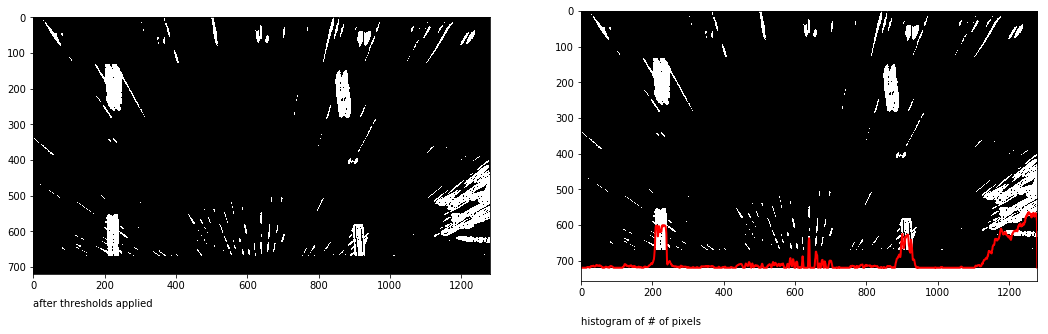

In [19]:
fig = plt.figure(figsize=(18, 8))
a = fig.add_subplot(1, 2, 1)
plt.imshow(t3.img, cmap='gray')
plt.text(0, 810, "after thresholds applied")

a = fig.add_subplot(1, 2, 2)
histogram = np.sum(t3.img[int(t3.img.shape[0]/2):,:], axis=0)
plt.imshow(t3.img, cmap='gray')

# Subtract histogram values from max values so the histogram can be drawn
# at the bottom of the plot.
a.plot(t3.img.shape[0] - histogram, '-', c='#FF0000', lw=2)
_ = plt.text(0, 880, "histogram of # of pixels")

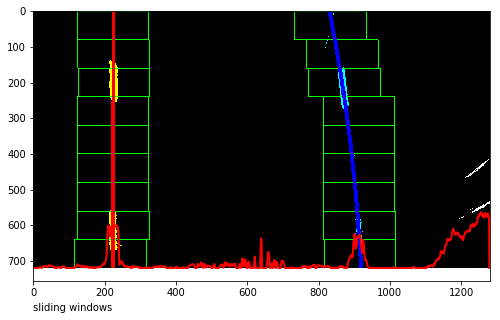

In [31]:
fig = plt.figure(figsize=(18, 8))
a = fig.add_subplot(1, 2, 1)

histogram = np.sum(t3.img[int(t3.img.shape[0]/2):,:], axis=0)
plt.imshow(an.map)

# Subtract histogram values from max values so the histogram can be drawn
# at the bottom of the plot.
a.plot(t3.img.shape[0] - histogram, '-', c='#FF0000', lw=2)
_ = plt.text(0, 840, "sliding windows")

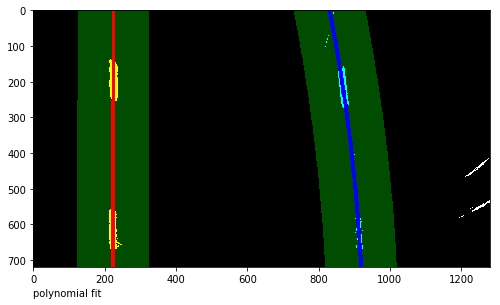

In [32]:
fig = plt.figure(figsize=(18, 8))
a = fig.add_subplot(1, 2, 1)
processed = ip_vid.process(img)
plt.imshow(an.map)
_ = plt.text(0, 800, "polynomial fit")

In [33]:
f.reset()
output = 'project_video_processed.mp4'
clip2 = VideoFileClip('project_video.mp4')
clip = clip2.fl_image(ip_vid.process)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:38<00:00,  4.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed.mp4 

Wall time: 4min 39s


In [6]:
f.reset()
output = 'challenge_video_processed.mp4'
clip2 = VideoFileClip('challenge_video.mp4')
clip = clip2.fl_image(ip_vid.process)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video challenge_video_processed.mp4
[MoviePy] Writing video challenge_video_processed.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:50<00:00,  4.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_processed.mp4 

Wall time: 1min 51s


In [37]:
f.reset()
output = 'harder_challenge_video_processed.mp4'
clip2 = VideoFileClip('harder_challenge_video.mp4')
clip = clip2.fl_image(ip_vid.process)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_processed.mp4
[MoviePy] Writing video harder_challenge_video_processed.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [04:52<00:00,  3.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_processed.mp4 

Wall time: 4min 53s
